In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dropout, Dense, Layer
from sklearn.preprocessing import StandardScaler
import warnings
from keras.callbacks import EarlyStopping
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras.optimizers import Adam
import keras.backend as K
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.0f}'.format)
import os
import tensorflow as tf
from datetime import datetime

In [ ]:
def results(a,b,c,d,e,f,g):
    current_time = datetime.now()
    data = {
        'model' : [g],
        'sim' : [a],
        'mae' : [b],
        'rmse' : [c],
        'fsd' : [d],
        'R' : [e],
        'NSE': [f],
        'time' : [current_time]
    }
    df = pd.DataFrame(data)
    with open('results_combine.csv', 'a', newline='') as f:
        if os.path.isfile('results_combine.csv'):
            df.to_csv('results_combine.csv', mode='a', header=False, index=False)
        else:
            df.to_csv('results_combine.csv', index=False)

def to_df(data_list):
    X_df = [i[:-1] for i in data_list]
    y_df = [i[-1] for i in data_list]
    transposed_lists = [list(x) for x in zip(*X_df)]

    df_list = pd.DataFrame({f'Column{i+1}': lst for i, lst in enumerate(transposed_lists)})
    df_list['Target'] = y_df
    return df_list

def transform_to_multivariate(data, T):
    M = []
    for i in range(len(data) - T):
        row = data[i:i + T + 1]
        M.append(row)
    return np.array(M)

def calculate_similarity(value_lst_after, value_lst_before):
        T = len(value_lst_after)  # Number of missing values
        similarity_sum = 0

        for i in range(T):
            yi = value_lst_after[i]
            xi = value_lst_before[i]
            similarity_sum += 1 / (1 + abs(yi - xi) / (max(value_lst_before) - min(value_lst_before)))

        similarity = similarity_sum / T
        return similarity

def calculate_MAE(value_lst_missing, value_lst_after):
        return mean_absolute_error(value_lst_missing, value_lst_after)

def calculate_RMSE(value_lst_missing, value_lst_after):
    return np.sqrt(mean_squared_error(value_lst_missing, value_lst_after))

def calculate_FB(value_lst_missing, value_lst_after):
    return 2 * abs((np.mean(value_lst_after) - np.mean(value_lst_missing)) / (np.mean(value_lst_after) + np.mean(value_lst_missing)))

def calculate_fsd(value_lst_missing, value_lst_after):
    std_dev_Y = np.std(value_lst_after)
    std_dev_X = np.std(value_lst_missing)

    if std_dev_X == 0:
        return None
    
    fsd = 2 * abs((std_dev_Y - std_dev_X) / (std_dev_X + std_dev_Y))
    
    return fsd

def calculate_r_score(value_lst_missing, value_lst_after):

    correlation_matrix = np.corrcoef(value_lst_missing, value_lst_after)
    r_score = correlation_matrix[0, 1]
    return r_score

def calculate_nse(value_lst_missing, value_lst_after):

    value_lst_missing = np.array(value_lst_missing)
    value_lst_after = np.array(value_lst_after)

    numerator = np.sum((value_lst_missing - value_lst_after)**2)
    denominator = np.sum((value_lst_missing - np.mean(value_lst_missing))**2)

    nse = 1 - (numerator / denominator)
    
    return nse

def calculate_metrics_for_combine(value_lst_after,name_model):
    
    df_before_missing = pd.read_csv('waterlevel.csv')
    value_lst_missing = df_before_missing['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap]


    similarity_score = calculate_similarity(value_lst_after, value_lst_missing)
    MAE_score = calculate_MAE(value_lst_missing, value_lst_after)
    RMSE_score = calculate_RMSE(value_lst_missing, value_lst_after)
    FSD_score = calculate_fsd(value_lst_missing, value_lst_after)
    R_score = calculate_r_score(value_lst_missing, value_lst_after)
    NSE_score = calculate_nse(value_lst_missing, value_lst_after)
    
    sim_lst_combine.append(similarity_score)
    mae_lst_combine.append(MAE_score)
    rmse_lst_combine.append(RMSE_score)
    fsd_lst_combine.append(FSD_score)
    r_lst_combine.append(R_score)
    nse_lst_combine.append(NSE_score)

    
    print('\nOri_data:', value_lst_missing)
    print('\nvalue_data:', value_lst_after)
    print('\nSimilarity_score:', similarity_score)
    print('\nMean Absolute Error (MAE):', MAE_score)
    print('\nRoot Mean Squared Error (RMSE):', RMSE_score)
    print('\nFraction of Standard Deviation Score:', FSD_score)
    print('\nR score:', R_score)
    print('\nThe Nash Sutcliffe efficiency (NSE):', NSE_score)

    results(similarity_score, MAE_score, RMSE_score, FSD_score, R_score, NSE_score,name_model)

def create_continuous_missing_values(dataframe, column_name, num_missing_values):
    modified_df = dataframe.copy()
    
    if len(dataframe) > num_missing_values:
        random_index = random.randint(0, len(dataframe) - num_missing_values)
        modified_df.loc[random_index:random_index + num_missing_values - 1, column_name] = np.nan
    else:
        print("Error: The number of missing values requested exceeds the DataFrame's capacity.")
    return modified_df


sim_lst_combine = []
mae_lst_combine = []
rmse_lst_combine = []
fsd_lst_combine = []
r_lst_combine = []
nse_lst_combine = []

scaler = StandardScaler()

In [ ]:
# original_df_path = 'waterlevel.csv'
# try:
#     original_df = pd.read_csv(original_df_path)
    
#     for i in range(0, 12):
#         modified_df = create_continuous_missing_values(original_df, 'Waterlevel', 48)
#         modified_df.to_csv(f'waterlevel_missing_test_{i}.csv', index=False)
        
#         print(f'waterlevel_missing_test_{i}.csv saved with continuous missing values.')

# except FileNotFoundError:
#     print(f"Failed to find '{original_df_path}'. Please check the file path and try again.")

In [ ]:
def model_combine(X_train):
    combine = tf.keras.models.Sequential()

    combine.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    combine.add(MaxPooling1D(pool_size=2))
    combine.add(Dropout(0.15))
    
    combine.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    combine.add(Dropout(0.15))
    
    combine.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    combine.add(Dropout(0.15))
    
    combine.add(Bidirectional(LSTM(units=256, return_sequences=True)))
    combine.add(Dropout(0.15))

    class Attention(Layer):
        def __init__(self, **kwargs):
            super(Attention, self).__init__(**kwargs)
    
        def build(self, input_shape):
            self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), 
                                     initializer='random_normal', trainable=True)
            self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1), 
                                     initializer='zeros', trainable=True)        
            super(Attention, self).build(input_shape)
     
        def call(self, x):
            e = K.tanh(K.dot(x, self.W) + self.b)
            e = K.squeeze(e, axis=-1)
            alpha = K.softmax(e)
            alpha = K.expand_dims(alpha, axis=-1)
            context = x * alpha
            context = K.sum(context, axis=1)
            return context

    combine.add(Attention())
    
    combine.add(Dense(units=256, activation='relu'))
    
    combine.add(Dense(units=1))
    
    combine.compile(optimizer=Adam(), loss="mean_squared_error", metrics=['mae'])
    
    return combine

### epochs=200, batch_size=16, callbacks (patience=30), validation_split=0.2

1558/1558 [==============================] - 15s 10ms/step - loss: 27.1371 - mae: 3.8996 - val_loss: 12.8501 - val_mae: 2.6902
Epoch 32/200
1558/1558 [==============================] - 14s 9ms/step - loss: 27.8792 - mae: 3.9104 - val_loss: 10.7773 - val_mae: 2.5391
Epoch 33/200
1558/1558 [==============================] - 13s 9ms/step - loss: 26.2128 - mae: 3.8089 - val_loss: 18.9981 - val_mae: 3.6609
Epoch 34/200
1558/1558 [==============================] - 13s 9ms/step - loss: 26.2567 - mae: 3.8058 - val_loss: 16.8806 - val_mae: 3.3292
Epoch 35/200
1558/1558 [==============================] - 13s 9ms/step - loss: 25.9403 - mae: 3.8057 - val_loss: 11.8633 - val_mae: 2.6199
Epoch 36/200
1558/1558 [==============================] - 13s 9ms/step - loss: 25.0342 - mae: 3.7456 - val_loss: 9.7455 - val_mae: 2.3990
Epoch 37/200
1558/1558 [==============================] - 13s 9ms/step - loss: 24.9143 - mae: 3.7102 - val_loss: 10.3729 - val_mae: 2.4383
Epoch 38/200
1558/1558 [================

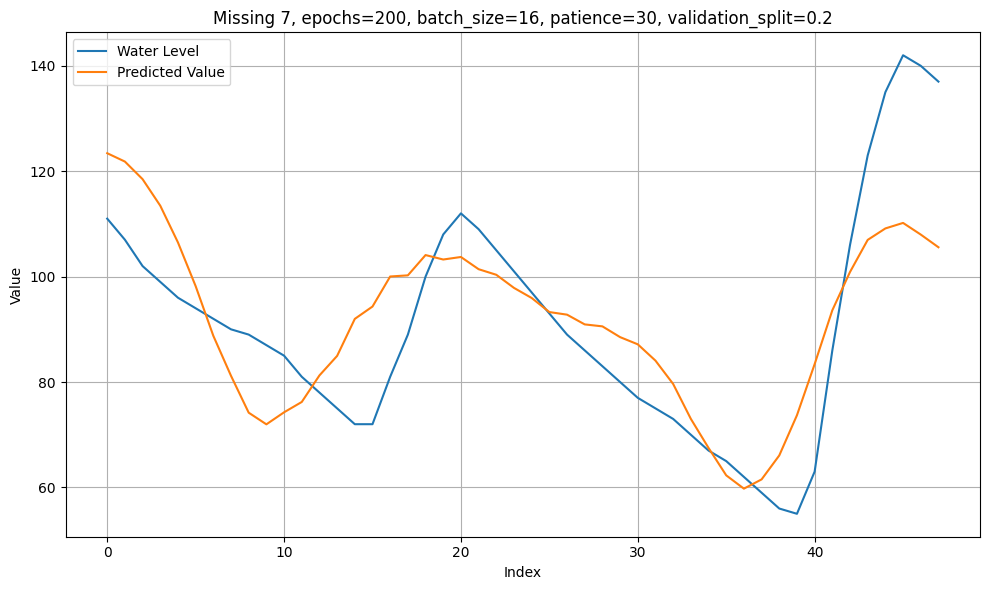

Epoch 1/200
2751/2751 [==============================] - 25s 9ms/step - loss: 2167.4536 - mae: 26.3447 - val_loss: 107.1842 - val_mae: 6.4702
Epoch 2/200
2751/2751 [==============================] - 23s 8ms/step - loss: 67.5518 - mae: 6.0637 - val_loss: 58.6387 - val_mae: 4.5518
Epoch 3/200
2751/2751 [==============================] - 23s 8ms/step - loss: 51.3721 - mae: 5.2938 - val_loss: 39.6897 - val_mae: 4.2100
Epoch 4/200
2751/2751 [==============================] - 23s 8ms/step - loss: 46.6489 - mae: 5.0770 - val_loss: 33.2987 - val_mae: 3.6417
Epoch 5/200
2751/2751 [==============================] - 23s 8ms/step - loss: 39.6089 - mae: 4.6959 - val_loss: 39.5487 - val_mae: 4.1896
Epoch 6/200
2751/2751 [==============================] - 23s 8ms/step - loss: 37.1437 - mae: 4.5291 - val_loss: 150.0005 - val_mae: 5.5390
Epoch 7/200
2751/2751 [==============================] - 23s 8ms/step - loss: 33.4780 - mae: 4.3225 - val_loss: 65.7168 - val_mae: 4.8697
Epoch 8/200
2751/2751 [======

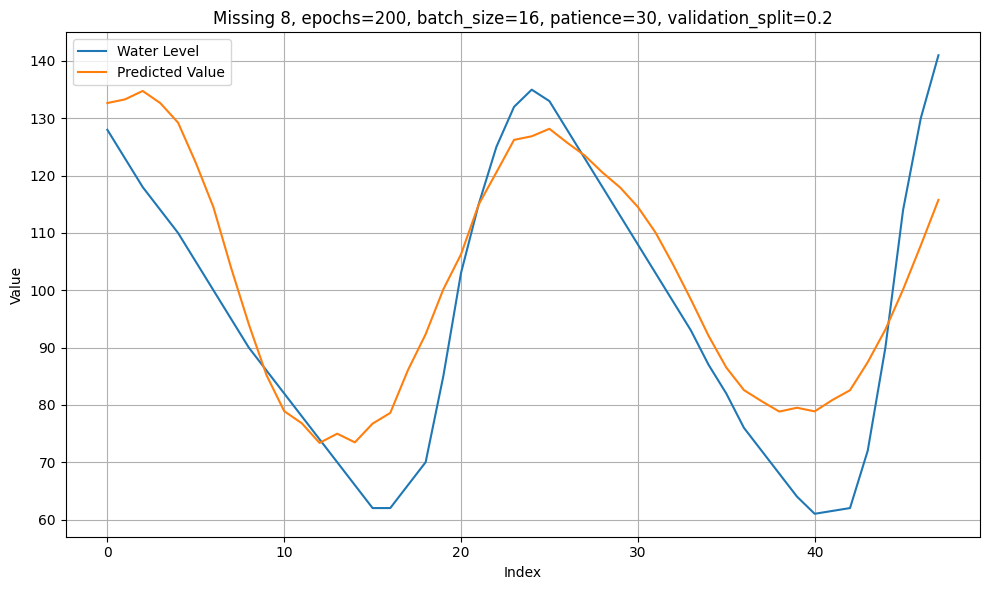

Epoch 1/200
146/146 [==============================] - 3s 12ms/step - loss: 1676.4113 - mae: 32.8708 - val_loss: 1346.0596 - val_mae: 30.8915
Epoch 2/200
146/146 [==============================] - 1s 9ms/step - loss: 1365.9120 - mae: 30.2677 - val_loss: 1324.7280 - val_mae: 30.6311
Epoch 3/200
146/146 [==============================] - 1s 8ms/step - loss: 919.4735 - mae: 23.5404 - val_loss: 181.0891 - val_mae: 9.8189
Epoch 4/200
146/146 [==============================] - 1s 8ms/step - loss: 87.6700 - mae: 7.2135 - val_loss: 88.8969 - val_mae: 7.8209
Epoch 5/200
146/146 [==============================] - 1s 8ms/step - loss: 51.7035 - mae: 5.6194 - val_loss: 52.9135 - val_mae: 5.2409
Epoch 6/200
146/146 [==============================] - 1s 8ms/step - loss: 36.2171 - mae: 4.6580 - val_loss: 48.1554 - val_mae: 5.6119
Epoch 7/200
146/146 [==============================] - 1s 8ms/step - loss: 29.8412 - mae: 4.2387 - val_loss: 28.5808 - val_mae: 4.1372
Epoch 8/200
146/146 [==================

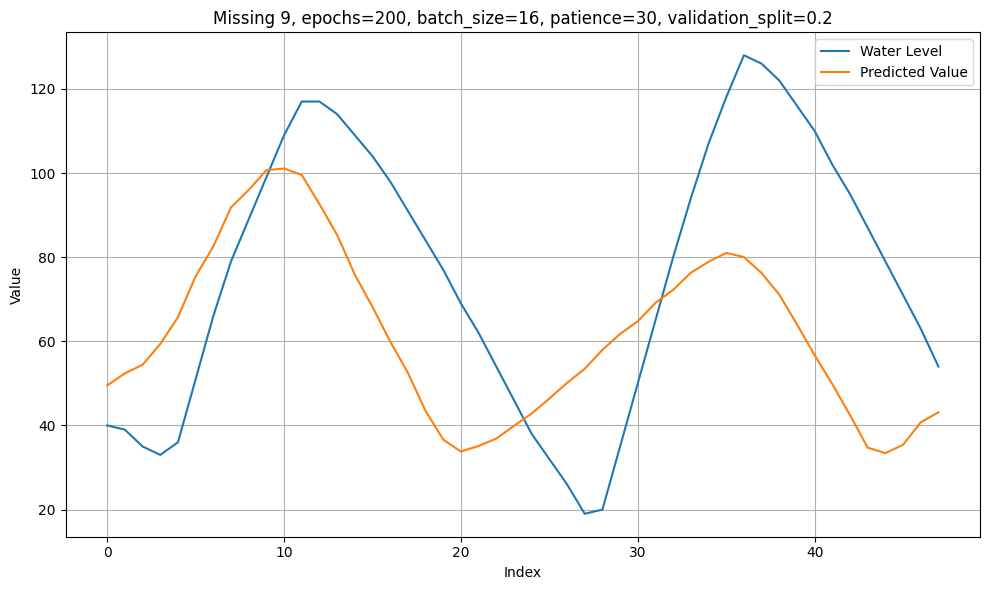

Epoch 1/200
1960/1960 [==============================] - 18s 8ms/step - loss: 1313.0448 - mae: 19.8712 - val_loss: 59.4263 - val_mae: 6.2090
Epoch 2/200
1960/1960 [==============================] - 16s 8ms/step - loss: 94.5440 - mae: 7.1134 - val_loss: 22.2342 - val_mae: 3.6086
Epoch 3/200
1960/1960 [==============================] - 16s 8ms/step - loss: 67.1407 - mae: 6.0399 - val_loss: 24.6030 - val_mae: 3.8100
Epoch 4/200
1960/1960 [==============================] - 16s 8ms/step - loss: 56.1075 - mae: 5.5731 - val_loss: 39.2458 - val_mae: 5.1376
Epoch 5/200
1960/1960 [==============================] - 16s 8ms/step - loss: 50.9605 - mae: 5.2913 - val_loss: 21.2441 - val_mae: 3.5150
Epoch 6/200
1960/1960 [==============================] - 16s 8ms/step - loss: 44.5145 - mae: 4.9387 - val_loss: 43.8487 - val_mae: 5.7475
Epoch 7/200
1960/1960 [==============================] - 16s 8ms/step - loss: 42.6616 - mae: 4.8313 - val_loss: 12.6979 - val_mae: 2.7132
Epoch 8/200
1960/1960 [========

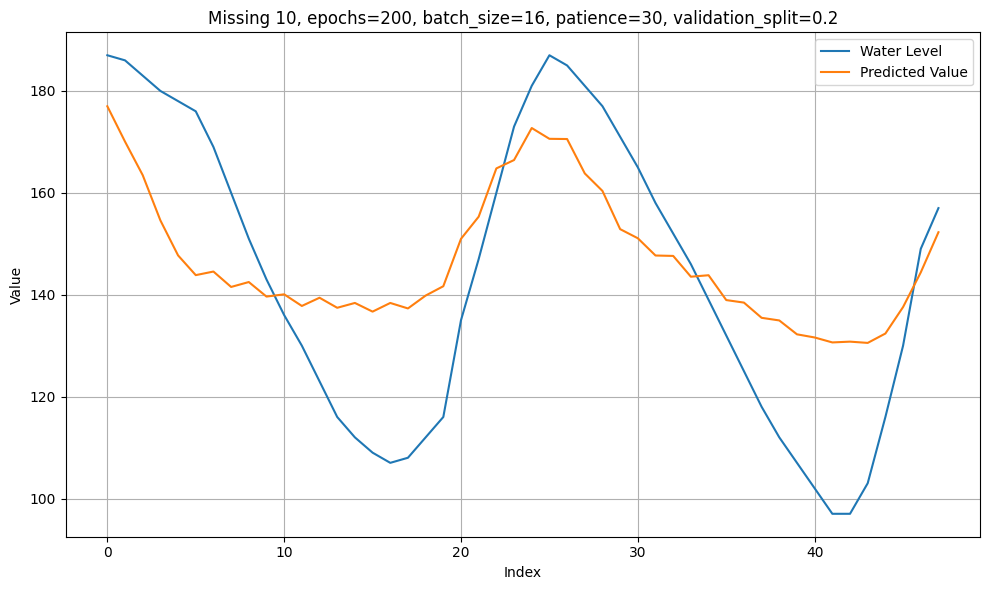

Epoch 1/200
457/457 [==============================] - 6s 11ms/step - loss: 3654.8936 - mae: 46.2609 - val_loss: 991.5551 - val_mae: 26.4473
Epoch 2/200
457/457 [==============================] - 4s 9ms/step - loss: 858.8738 - mae: 21.8137 - val_loss: 80.1387 - val_mae: 7.2297
Epoch 3/200
457/457 [==============================] - 4s 9ms/step - loss: 109.6128 - mae: 7.8410 - val_loss: 75.8487 - val_mae: 7.5168
Epoch 4/200
457/457 [==============================] - 4s 9ms/step - loss: 69.2067 - mae: 6.3184 - val_loss: 39.6689 - val_mae: 5.2980
Epoch 5/200
457/457 [==============================] - 4s 9ms/step - loss: 55.2303 - mae: 5.7466 - val_loss: 48.8557 - val_mae: 5.9978
Epoch 6/200
457/457 [==============================] - 4s 9ms/step - loss: 54.0588 - mae: 5.5397 - val_loss: 26.1071 - val_mae: 4.0674
Epoch 7/200
457/457 [==============================] - 4s 9ms/step - loss: 44.2886 - mae: 5.0662 - val_loss: 14.7472 - val_mae: 3.0253
Epoch 8/200
457/457 [=========================

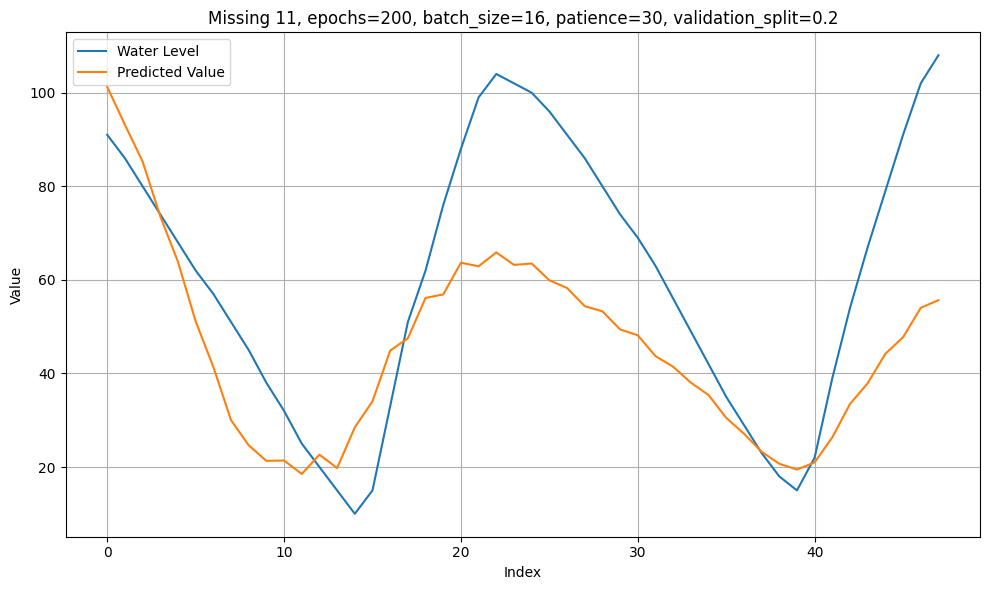




Mean of Similarity combine:  0.8081064620968254

Mean of Mean Absoulute Error combine : 23.335006750587905

Mean of Root Mean Squared Error combine:  27.663562157377385

Mean of Fraction of Standard Deviation combine:  0.3896827351935425

Mean of R-score combine:  0.6003852026153886

Mean of the Nash Sutcliffe efficiency (NSE):  -1.371471161094231




In [11]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(True)

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)


for location in range(0,12):
    
    filename = f'waterlevel_missing/waterlevel_missing_{location}.csv'
    df = pd.read_csv(filename)
    
    #### Check size of missing value
    size_of_gap = df['Waterlevel'].isna().sum()

    data = df['Waterlevel'].values.tolist()

    nan_index = None
    for j, value in enumerate(data):
        if value != value:  # Check if the value is NaN
            nan_index = j
            break
        
    df_check_before = data[:(3*size_of_gap)+1]
    df_check_after = data[::-1][:3*size_of_gap+1]
    df_miss = data[nan_index:nan_index + size_of_gap]

    last_data = data[:nan_index]
    first_data = data[nan_index+size_of_gap:][::-1]

    # check if missing values is in the first 3 x T data original
    if all(value in df_check_before for value in df_miss):
        print('\nAll values in df_miss is in the first !!!')

        first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
        df_list = to_df(first_value_combine)
        

        X = np.array(df_list.iloc[:, :-1])
        X = scaler.fit_transform(X)
        
        y = np.array(df_list.iloc[:, -1])
        
        model = model_combine(X)
        model.fit(X, y, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)

        data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
        data_test = np.concatenate(data_test).ravel()   

        results_first_combine = []
        for i in range(len(data_test)//2):
            data_first = data_test[i:i+1+size_of_gap]

            data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

            results_first_combine.append(data_first[size_of_gap])
            
        ###################################################################
        print('\n', 'result of combine only (first):')                        #  
        calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
        print('\n')                                                       #
        ###################################################################
        
        df = pd.read_csv('Impute_misvalues_hungyen.csv')

        plt.figure(figsize=(10, 6))
        plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
        plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
        plt.title(f'Missing {location}, epochs=200, batch_size=16, patience=30, validation_split=0.2')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        folder_path = 'T:\Python\SU24\AIL\HY\\128,256,512,256,256'
        filename = f'128,256,512,256,256, Missing {location}, epochs=200, batch_size=16, patience=30, validation_split=0.2.png'
        full_path = os.path.join(folder_path, filename)
        plt.savefig(full_path)
        plt.show()
        
    elif all(value in df_check_after for value in df_miss):
        print('\nAll values in df_miss is in the last !!!')
        
        last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
        df_list = to_df(last_value_combine)

        X = np.array(df_list.iloc[:, :-1])
        X = scaler.fit_transform(X)
        
        y = np.array(df_list.iloc[:, -1])
        
        model = model_combine(X)
        model.fit(X, y, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)

        data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
        data_test = np.concatenate(data_test).ravel()   

        results_last_combine = []
        for i in range(len(data_test)//2):
            data_last = data_test[i:i+1+size_of_gap]

            data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

            results_last_combine.append(data_last[size_of_gap])
            
        #################################################################
        print('\n', 'result of combine only (last):')                       #
        calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
        print('\n')                                                     #
        # #################################################################
        
        df = pd.read_csv('Impute_misvalues_hungyen.csv')

        plt.figure(figsize=(10, 6))
        plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
        plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
        plt.title(f'Missing {location}, epochs=200, batch_size=16, patience=30, validation_split=0.2')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        folder_path = 'T:\Python\SU24\AIL\HY\\128,256,512,256,256'
        filename = f'128,256,512,256,256, Missing {location}, epochs=200, batch_size=16, patience=30, validation_split=0.2.png'
        full_path = os.path.join(folder_path, filename)
        plt.savefig(full_path)
        plt.show()
        
    else:
        Da = data[nan_index + size_of_gap:][::-1]

        MDa = transform_to_multivariate(Da, size_of_gap)

        df_MDa = to_df(MDa)

        X_MDa_train = np.array(df_MDa.iloc[:, :-1])
        X_MDa_train = scaler.fit_transform(X_MDa_train)
        
        y_MDa_train = np.array(df_MDa.iloc[:, -1])

        model_MDa = model_combine(X_MDa_train)
        model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)
        
        data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
        data_test_after = np.concatenate(data_test_after).ravel()   

        value_lst_after = []
        for j in range(len(data_test_after)//2):
            data_after = data_test_after[j:j+1+size_of_gap]
            
            data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
            value_lst_after.append(data_after[size_of_gap])

        Db = data[:nan_index]

        MDb = transform_to_multivariate(Db, size_of_gap)  

        df_MDb = to_df(MDb)

        X_MDb_train = np.array(df_MDb.iloc[:, :-1])
        X_MDb_train = scaler.fit_transform(X_MDb_train)
        
        y_MDb_train = np.array(df_MDb.iloc[:, -1])

        model_MDb = model_combine(X_MDb_train)
        model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)

        data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
        data_test_before = np.concatenate(data_test_before).ravel()   

        value_lst_before = []
        for i in range(len(data_test_before)//2):
            data_before = data_test_before[i:i+1+size_of_gap]
            
            data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

            value_lst_before.append(data_before[size_of_gap])

        #############################################################################
        print('\n', 'result of combine only: ')                                         #
        results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
        calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
        print('\n')                                                                 #
        #############################################################################
        
        df = pd.read_csv('Impute_misvalues_hungyen.csv')

        plt.figure(figsize=(10, 6))
        plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
        plt.plot(results_combine, label='Predicted Value', linestyle='-')
        plt.title(f'Missing {location}, epochs=200, batch_size=16, patience=30, validation_split=0.2')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()   
        folder_path = 'T:\Python\SU24\AIL\HY\\128,256,512,256,256'
        filename = f'128,256,512,256,256, Missing {location}, epochs=200, batch_size=16, patience=30, validation_split=0.2.png'
        full_path = os.path.join(folder_path, filename)
        plt.savefig(full_path)
        plt.show()
    
    
current_time = datetime.now()

print('\n')
print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
print('\nMean of R-score combine: ', np.mean(r_lst_combine))
print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
print('\n')

### epochs=200, batch_size=8, callbacks (patience=30), validation_split=0.2

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # tf.debugging.set_log_device_placement(True)

# early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)


# for location in range(0,12):
    
#     filename = f'waterlevel_missing_{location}.csv'
#     df = pd.read_csv(filename)
    
#     #### Check size of missing value
#     size_of_gap = df['Waterlevel'].isna().sum()

#     data = df['Waterlevel'].values.tolist()

#     nan_index = None
#     for j, value in enumerate(data):
#         if value != value:  # Check if the value is NaN
#             nan_index = j
#             break
        
#     df_check_before = data[:(3*size_of_gap)+1]
#     df_check_after = data[::-1][:3*size_of_gap+1]
#     df_miss = data[nan_index:nan_index + size_of_gap]

#     last_data = data[:nan_index]
#     first_data = data[nan_index+size_of_gap:][::-1]

#     # check if missing values is in the first 3 x T data original
#     if all(value in df_check_before for value in df_miss):
#         print('\nAll values in df_miss is in the first !!!')

#         first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
#         df_list = to_df(first_value_combine)
        

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=8, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
#         data_test = np.concatenate(data_test).ravel()   

#         results_first_combine = []
#         for i in range(len(data_test)//2):
#             data_first = data_test[i:i+1+size_of_gap]

#             data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

#             results_first_combine.append(data_first[size_of_gap])
            
#         ###################################################################
#         print('\n', 'result of combine only (first):')                        #  
#         calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
#         print('\n')                                                       #
#         ###################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Missing {location}, epochs=200, batch_size=8, patience=30, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=8, patience=30, validation_split=0.2.png')
#         plt.show()
        
#     elif all(value in df_check_after for value in df_miss):
#         print('\nAll values in df_miss is in the last !!!')
        
#         last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
#         df_list = to_df(last_value_combine)

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=8, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test = np.concatenate(data_test).ravel()   

#         results_last_combine = []
#         for i in range(len(data_test)//2):
#             data_last = data_test[i:i+1+size_of_gap]

#             data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

#             results_last_combine.append(data_last[size_of_gap])
            
#         #################################################################
#         print('\n', 'result of combine only (last):')                       #
#         calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
#         print('\n')                                                     #
#         # #################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Missing {location}, epochs=200, batch_size=8, patience=30, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=8, patience=30, validation_split=0.2.png')
#         plt.show()
        
#     else:
#         Da = data[nan_index + size_of_gap:][::-1]

#         MDa = transform_to_multivariate(Da, size_of_gap)

#         df_MDa = to_df(MDa)

#         X_MDa_train = np.array(df_MDa.iloc[:, :-1])
#         X_MDa_train = scaler.fit_transform(X_MDa_train)
        
#         y_MDa_train = np.array(df_MDa.iloc[:, -1])

#         model_MDa = model_combine(X_MDa_train)
#         model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=8, callbacks=[early_stopping], validation_split=0.2)
        
#         data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
#         data_test_after = np.concatenate(data_test_after).ravel()   

#         value_lst_after = []
#         for j in range(len(data_test_after)//2):
#             data_after = data_test_after[j:j+1+size_of_gap]
            
#             data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
#             value_lst_after.append(data_after[size_of_gap])

#         Db = data[:nan_index]

#         MDb = transform_to_multivariate(Db, size_of_gap)  

#         df_MDb = to_df(MDb)

#         X_MDb_train = np.array(df_MDb.iloc[:, :-1])
#         X_MDb_train = scaler.fit_transform(X_MDb_train)
        
#         y_MDb_train = np.array(df_MDb.iloc[:, -1])

#         model_MDb = model_combine(X_MDb_train)
#         model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=8, callbacks=[early_stopping], validation_split=0.2)

#         data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test_before = np.concatenate(data_test_before).ravel()   

#         value_lst_before = []
#         for i in range(len(data_test_before)//2):
#             data_before = data_test_before[i:i+1+size_of_gap]
            
#             data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

#             value_lst_before.append(data_before[size_of_gap])

#         #############################################################################
#         print('\n', 'result of combine only: ')                                         #
#         results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
#         calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
#         print('\n')                                                                 #
#         #############################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Missing {location}, epochs=200, batch_size=8, patience=30, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()   
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=8, patience=30, validation_split=0.2.png')
#         plt.show()
    
    
# current_time = datetime.now()

# print('\n')
# print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
# print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
# print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
# print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
# print('\nMean of R-score combine: ', np.mean(r_lst_combine))
# print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
# print('\n')

### epochs=200, batch_size=32, callbacks (patience=30), validation_split=0.2

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # tf.debugging.set_log_device_placement(True)

# early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)


# for location in range(0,12):
    
#     filename = f'waterlevel_missing_{location}.csv'
#     df = pd.read_csv(filename)
    
#     #### Check size of missing value
#     size_of_gap = df['Waterlevel'].isna().sum()

#     data = df['Waterlevel'].values.tolist()

#     nan_index = None
#     for j, value in enumerate(data):
#         if value != value:  # Check if the value is NaN
#             nan_index = j
#             break
        
#     df_check_before = data[:(3*size_of_gap)+1]
#     df_check_after = data[::-1][:3*size_of_gap+1]
#     df_miss = data[nan_index:nan_index + size_of_gap]

#     last_data = data[:nan_index]
#     first_data = data[nan_index+size_of_gap:][::-1]

#     # check if missing values is in the first 3 x T data original
#     if all(value in df_check_before for value in df_miss):
#         print('\nAll values in df_miss is in the first !!!')

#         first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
#         df_list = to_df(first_value_combine)
        

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=32, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
#         data_test = np.concatenate(data_test).ravel()   

#         results_first_combine = []
#         for i in range(len(data_test)//2):
#             data_first = data_test[i:i+1+size_of_gap]

#             data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

#             results_first_combine.append(data_first[size_of_gap])
            
#         ###################################################################
#         print('\n', 'result of combine only (first):')                        #  
#         calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
#         print('\n')                                                       #
#         ###################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=32, patience=30, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=32, patience=30, validation_split=0.2.png')
#         plt.show()
        
#     elif all(value in df_check_after for value in df_miss):
#         print('\nAll values in df_miss is in the last !!!')
        
#         last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
#         df_list = to_df(last_value_combine)

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=32, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test = np.concatenate(data_test).ravel()   

#         results_last_combine = []
#         for i in range(len(data_test)//2):
#             data_last = data_test[i:i+1+size_of_gap]

#             data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

#             results_last_combine.append(data_last[size_of_gap])
            
#         #################################################################
#         print('\n', 'result of combine only (last):')                       #
#         calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
#         print('\n')                                                     #
#         # #################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=32, patience=30, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=32, patience=30, validation_split=0.2.png')
#         plt.show()
        
#     else:
#         Da = data[nan_index + size_of_gap:][::-1]

#         MDa = transform_to_multivariate(Da, size_of_gap)

#         df_MDa = to_df(MDa)

#         X_MDa_train = np.array(df_MDa.iloc[:, :-1])
#         X_MDa_train = scaler.fit_transform(X_MDa_train)
        
#         y_MDa_train = np.array(df_MDa.iloc[:, -1])

#         model_MDa = model_combine(X_MDa_train)
#         model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=32, callbacks=[early_stopping], validation_split=0.2)
        
#         data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
#         data_test_after = np.concatenate(data_test_after).ravel()   

#         value_lst_after = []
#         for j in range(len(data_test_after)//2):
#             data_after = data_test_after[j:j+1+size_of_gap]
            
#             data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
#             value_lst_after.append(data_after[size_of_gap])

#         Db = data[:nan_index]

#         MDb = transform_to_multivariate(Db, size_of_gap)  

#         df_MDb = to_df(MDb)

#         X_MDb_train = np.array(df_MDb.iloc[:, :-1])
#         X_MDb_train = scaler.fit_transform(X_MDb_train)
        
#         y_MDb_train = np.array(df_MDb.iloc[:, -1])

#         model_MDb = model_combine(X_MDb_train)
#         model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=32, callbacks=[early_stopping], validation_split=0.2)

#         data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test_before = np.concatenate(data_test_before).ravel()   

#         value_lst_before = []
#         for i in range(len(data_test_before)//2):
#             data_before = data_test_before[i:i+1+size_of_gap]
            
#             data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

#             value_lst_before.append(data_before[size_of_gap])

#         #############################################################################
#         print('\n', 'result of combine only: ')                                         #
#         results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
#         calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
#         print('\n')                                                                 #
#         #############################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=32, patience=30, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.show()    
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=32, patience=30, validation_split=0.2.png')
    
    
# current_time = datetime.now()

# print('\n')
# print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
# print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
# print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
# print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
# print('\nMean of R-score combine: ', np.mean(r_lst_combine))
# print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
# print('\n')

### epochs=200, batch_size=8, callbacks (patience=50), validation_split=0.2

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # tf.debugging.set_log_device_placement(True)

# early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)


# for location in range(0,12):
    
#     filename = f'waterlevel_missing_{location}.csv'
#     df = pd.read_csv(filename)
    
#     #### Check size of missing value
#     size_of_gap = df['Waterlevel'].isna().sum()

#     data = df['Waterlevel'].values.tolist()

#     nan_index = None
#     for j, value in enumerate(data):
#         if value != value:  # Check if the value is NaN
#             nan_index = j
#             break
        
#     df_check_before = data[:(3*size_of_gap)+1]
#     df_check_after = data[::-1][:3*size_of_gap+1]
#     df_miss = data[nan_index:nan_index + size_of_gap]

#     last_data = data[:nan_index]
#     first_data = data[nan_index+size_of_gap:][::-1]

#     # check if missing values is in the first 3 x T data original
#     if all(value in df_check_before for value in df_miss):
#         print('\nAll values in df_miss is in the first !!!')

#         first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
#         df_list = to_df(first_value_combine)
        

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=8, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
#         data_test = np.concatenate(data_test).ravel()   

#         results_first_combine = []
#         for i in range(len(data_test)//2):
#             data_first = data_test[i:i+1+size_of_gap]

#             data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

#             results_first_combine.append(data_first[size_of_gap])
            
#         ###################################################################
#         print('\n', 'result of combine only (first):')                        #  
#         calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
#         print('\n')                                                       #
#         ###################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=8, patience=50, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=8, patience=50, validation_split=0.2.png')
#         plt.show()
        
#     elif all(value in df_check_after for value in df_miss):
#         print('\nAll values in df_miss is in the last !!!')
        
#         last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
#         df_list = to_df(last_value_combine)

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=8, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test = np.concatenate(data_test).ravel()   

#         results_last_combine = []
#         for i in range(len(data_test)//2):
#             data_last = data_test[i:i+1+size_of_gap]

#             data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

#             results_last_combine.append(data_last[size_of_gap])
            
#         #################################################################
#         print('\n', 'result of combine only (last):')                       #
#         calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
#         print('\n')                                                     #
#         # #################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=8, patience=50, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=8, patience=50, validation_split=0.2.png')
#         plt.show()
        
#     else:
#         Da = data[nan_index + size_of_gap:][::-1]

#         MDa = transform_to_multivariate(Da, size_of_gap)

#         df_MDa = to_df(MDa)

#         X_MDa_train = np.array(df_MDa.iloc[:, :-1])
#         X_MDa_train = scaler.fit_transform(X_MDa_train)
        
#         y_MDa_train = np.array(df_MDa.iloc[:, -1])

#         model_MDa = model_combine(X_MDa_train)
#         model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=8, callbacks=[early_stopping], validation_split=0.2)
        
#         data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
#         data_test_after = np.concatenate(data_test_after).ravel()   

#         value_lst_after = []
#         for j in range(len(data_test_after)//2):
#             data_after = data_test_after[j:j+1+size_of_gap]
            
#             data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
#             value_lst_after.append(data_after[size_of_gap])

#         Db = data[:nan_index]

#         MDb = transform_to_multivariate(Db, size_of_gap)  

#         df_MDb = to_df(MDb)

#         X_MDb_train = np.array(df_MDb.iloc[:, :-1])
#         X_MDb_train = scaler.fit_transform(X_MDb_train)
        
#         y_MDb_train = np.array(df_MDb.iloc[:, -1])

#         model_MDb = model_combine(X_MDb_train)
#         model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=8, callbacks=[early_stopping], validation_split=0.2)

#         data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test_before = np.concatenate(data_test_before).ravel()   

#         value_lst_before = []
#         for i in range(len(data_test_before)//2):
#             data_before = data_test_before[i:i+1+size_of_gap]
            
#             data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

#             value_lst_before.append(data_before[size_of_gap])

#         #############################################################################
#         print('\n', 'result of combine only: ')                                         #
#         results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
#         calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
#         print('\n')                                                                 #
#         #############################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=8, patience=50, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.show()    
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=8, patience=50, validation_split=0.2.png')
    
    
# current_time = datetime.now()

# print('\n')
# print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
# print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
# print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
# print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
# print('\nMean of R-score combine: ', np.mean(r_lst_combine))
# print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
# print('\n')

### epochs=200, batch_size=16, callbacks (patience=50), validation_split=0.2

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(True)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)


for location in range(0,12):
    
    filename = f'waterlevel_missing_{location}.csv'
    df = pd.read_csv(filename)
    
    #### Check size of missing value
    size_of_gap = df['Waterlevel'].isna().sum()

    data = df['Waterlevel'].values.tolist()

    nan_index = None
    for j, value in enumerate(data):
        if value != value:  # Check if the value is NaN
            nan_index = j
            break
        
    df_check_before = data[:(3*size_of_gap)+1]
    df_check_after = data[::-1][:3*size_of_gap+1]
    df_miss = data[nan_index:nan_index + size_of_gap]

    last_data = data[:nan_index]
    first_data = data[nan_index+size_of_gap:][::-1]

    # check if missing values is in the first 3 x T data original
    if all(value in df_check_before for value in df_miss):
        print('\nAll values in df_miss is in the first !!!')

        first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
        df_list = to_df(first_value_combine)
        

        X = np.array(df_list.iloc[:, :-1])
        X = scaler.fit_transform(X)
        
        y = np.array(df_list.iloc[:, -1])
        
        model = model_combine(X)
        model.fit(X, y, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)

        data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
        data_test = np.concatenate(data_test).ravel()   

        results_first_combine = []
        for i in range(len(data_test)//2):
            data_first = data_test[i:i+1+size_of_gap]

            data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

            results_first_combine.append(data_first[size_of_gap])
            
        ###################################################################
        print('\n', 'result of combine only (first):')                        #  
        calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
        print('\n')                                                       #
        ###################################################################
        
        df = pd.read_csv('Impute_misvalues_hungyen.csv')

        plt.figure(figsize=(10, 6))
        plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
        plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
        plt.title(f'Mising {location}, epochs=200, batch_size=16, patience=50, validation_split=0.2')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'64,128,256,200,200, Missing {location}, epochs=200, batch_size=16, patience=50, validation_split=0.2.png')
        plt.show()
        
    elif all(value in df_check_after for value in df_miss):
        print('\nAll values in df_miss is in the last !!!')
        
        last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
        df_list = to_df(last_value_combine)

        X = np.array(df_list.iloc[:, :-1])
        X = scaler.fit_transform(X)
        
        y = np.array(df_list.iloc[:, -1])
        
        model = model_combine(X)
        model.fit(X, y, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)

        data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
        data_test = np.concatenate(data_test).ravel()   

        results_last_combine = []
        for i in range(len(data_test)//2):
            data_last = data_test[i:i+1+size_of_gap]

            data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

            results_last_combine.append(data_last[size_of_gap])
            
        #################################################################
        print('\n', 'result of combine only (last):')                       #
        calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
        print('\n')                                                     #
        # #################################################################
        
        df = pd.read_csv('Impute_misvalues_hungyen.csv')

        plt.figure(figsize=(10, 6))
        plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
        plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
        plt.title(f'Mising {location}, epochs=200, batch_size=16, patience=50, validation_split=0.2')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'64,128,256,200,200, Missing {location}, epochs=200, batch_size=16, patience=50, validation_split=0.2.png')
        plt.show()
        
    else:
        Da = data[nan_index + size_of_gap:][::-1]

        MDa = transform_to_multivariate(Da, size_of_gap)

        df_MDa = to_df(MDa)

        X_MDa_train = np.array(df_MDa.iloc[:, :-1])
        X_MDa_train = scaler.fit_transform(X_MDa_train)
        
        y_MDa_train = np.array(df_MDa.iloc[:, -1])

        model_MDa = model_combine(X_MDa_train)
        model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)
        
        data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
        data_test_after = np.concatenate(data_test_after).ravel()   

        value_lst_after = []
        for j in range(len(data_test_after)//2):
            data_after = data_test_after[j:j+1+size_of_gap]
            
            data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
            value_lst_after.append(data_after[size_of_gap])

        Db = data[:nan_index]

        MDb = transform_to_multivariate(Db, size_of_gap)  

        df_MDb = to_df(MDb)

        X_MDb_train = np.array(df_MDb.iloc[:, :-1])
        X_MDb_train = scaler.fit_transform(X_MDb_train)
        
        y_MDb_train = np.array(df_MDb.iloc[:, -1])

        model_MDb = model_combine(X_MDb_train)
        model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)

        data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
        data_test_before = np.concatenate(data_test_before).ravel()   

        value_lst_before = []
        for i in range(len(data_test_before)//2):
            data_before = data_test_before[i:i+1+size_of_gap]
            
            data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

            value_lst_before.append(data_before[size_of_gap])

        #############################################################################
        print('\n', 'result of combine only: ')                                         #
        results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
        calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
        print('\n')                                                                 #
        #############################################################################
        
        df = pd.read_csv('Impute_misvalues_hungyen.csv')

        plt.figure(figsize=(10, 6))
        plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
        plt.plot(results_combine, label='Predicted Value', linestyle='-')
        plt.title(f'Mising {location}, epochs=200, batch_size=16, patience=50, validation_split=0.2')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()    
        plt.savefig(f'64,128,256,200,200, Missing {location}, epochs=200, batch_size=16, patience=50, validation_split=0.2.png')
    
    
current_time = datetime.now()

print('\n')
print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
print('\nMean of R-score combine: ', np.mean(r_lst_combine))
print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
print('\n')

### epochs=200, batch_size=32, callbacks (patience=50), validation_split=0.2

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # tf.debugging.set_log_device_placement(True)

# early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)


# for location in range(0,12):
    
#     filename = f'waterlevel_missing_{location}.csv'
#     df = pd.read_csv(filename)
    
#     #### Check size of missing value
#     size_of_gap = df['Waterlevel'].isna().sum()

#     data = df['Waterlevel'].values.tolist()

#     nan_index = None
#     for j, value in enumerate(data):
#         if value != value:  # Check if the value is NaN
#             nan_index = j
#             break
        
#     df_check_before = data[:(3*size_of_gap)+1]
#     df_check_after = data[::-1][:3*size_of_gap+1]
#     df_miss = data[nan_index:nan_index + size_of_gap]

#     last_data = data[:nan_index]
#     first_data = data[nan_index+size_of_gap:][::-1]

#     # check if missing values is in the first 3 x T data original
#     if all(value in df_check_before for value in df_miss):
#         print('\nAll values in df_miss is in the first !!!')

#         first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
#         df_list = to_df(first_value_combine)
        

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=32, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
#         data_test = np.concatenate(data_test).ravel()   

#         results_first_combine = []
#         for i in range(len(data_test)//2):
#             data_first = data_test[i:i+1+size_of_gap]

#             data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

#             results_first_combine.append(data_first[size_of_gap])
            
#         ###################################################################
#         print('\n', 'result of combine only (first):')                        #  
#         calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
#         print('\n')                                                       #
#         ###################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=32, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=32, callbacks (patience=50), validation_split=0.2.png')
#         plt.show()
        
#     elif all(value in df_check_after for value in df_miss):
#         print('\nAll values in df_miss is in the last !!!')
        
#         last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
#         df_list = to_df(last_value_combine)

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=32, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test = np.concatenate(data_test).ravel()   

#         results_last_combine = []
#         for i in range(len(data_test)//2):
#             data_last = data_test[i:i+1+size_of_gap]

#             data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

#             results_last_combine.append(data_last[size_of_gap])
            
#         #################################################################
#         print('\n', 'result of combine only (last):')                       #
#         calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
#         print('\n')                                                     #
#         # #################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=32, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=32, callbacks (patience=50), validation_split=0.2.png')
#         plt.show()
        
#     else:
#         Da = data[nan_index + size_of_gap:][::-1]

#         MDa = transform_to_multivariate(Da, size_of_gap)

#         df_MDa = to_df(MDa)

#         X_MDa_train = np.array(df_MDa.iloc[:, :-1])
#         X_MDa_train = scaler.fit_transform(X_MDa_train)
        
#         y_MDa_train = np.array(df_MDa.iloc[:, -1])

#         model_MDa = model_combine(X_MDa_train)
#         model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=32, callbacks=[early_stopping], validation_split=0.2)
        
#         data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
#         data_test_after = np.concatenate(data_test_after).ravel()   

#         value_lst_after = []
#         for j in range(len(data_test_after)//2):
#             data_after = data_test_after[j:j+1+size_of_gap]
            
#             data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
#             value_lst_after.append(data_after[size_of_gap])

#         Db = data[:nan_index]

#         MDb = transform_to_multivariate(Db, size_of_gap)  

#         df_MDb = to_df(MDb)

#         X_MDb_train = np.array(df_MDb.iloc[:, :-1])
#         X_MDb_train = scaler.fit_transform(X_MDb_train)
        
#         y_MDb_train = np.array(df_MDb.iloc[:, -1])

#         model_MDb = model_combine(X_MDb_train)
#         model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=32, callbacks=[early_stopping], validation_split=0.2)

#         data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test_before = np.concatenate(data_test_before).ravel()   

#         value_lst_before = []
#         for i in range(len(data_test_before)//2):
#             data_before = data_test_before[i:i+1+size_of_gap]
            
#             data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

#             value_lst_before.append(data_before[size_of_gap])

#         #############################################################################
#         print('\n', 'result of combine only: ')                                         #
#         results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
#         calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
#         print('\n')                                                                 #
#         #############################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=32, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.show()    
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=32, callbacks (patience=50), validation_split=0.2.png')
    
    
# current_time = datetime.now()

# print('\n')
# print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
# print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
# print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
# print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
# print('\nMean of R-score combine: ', np.mean(r_lst_combine))
# print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
# print('\n')

### epochs=200, batch_size=64, callbacks (patience=50), validation_split=0.2

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # tf.debugging.set_log_device_placement(True)

# early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)


# for location in range(0,12):
    
#     filename = f'waterlevel_missing_{location}.csv'
#     df = pd.read_csv(filename)
    
#     #### Check size of missing value
#     size_of_gap = df['Waterlevel'].isna().sum()

#     data = df['Waterlevel'].values.tolist()

#     nan_index = None
#     for j, value in enumerate(data):
#         if value != value:  # Check if the value is NaN
#             nan_index = j
#             break
        
#     df_check_before = data[:(3*size_of_gap)+1]
#     df_check_after = data[::-1][:3*size_of_gap+1]
#     df_miss = data[nan_index:nan_index + size_of_gap]

#     last_data = data[:nan_index]
#     first_data = data[nan_index+size_of_gap:][::-1]

#     # check if missing values is in the first 3 x T data original
#     if all(value in df_check_before for value in df_miss):
#         print('\nAll values in df_miss is in the first !!!')

#         first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
#         df_list = to_df(first_value_combine)
        

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=64, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
#         data_test = np.concatenate(data_test).ravel()   

#         results_first_combine = []
#         for i in range(len(data_test)//2):
#             data_first = data_test[i:i+1+size_of_gap]

#             data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

#             results_first_combine.append(data_first[size_of_gap])
            
#         ###################################################################
#         print('\n', 'result of combine only (first):')                        #  
#         calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
#         print('\n')                                                       #
#         ###################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=64, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=64, callbacks (patience=50), validation_split=0.2.png')
#         plt.show()
        
#     elif all(value in df_check_after for value in df_miss):
#         print('\nAll values in df_miss is in the last !!!')
        
#         last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
#         df_list = to_df(last_value_combine)

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=64, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test = np.concatenate(data_test).ravel()   

#         results_last_combine = []
#         for i in range(len(data_test)//2):
#             data_last = data_test[i:i+1+size_of_gap]

#             data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

#             results_last_combine.append(data_last[size_of_gap])
            
#         #################################################################
#         print('\n', 'result of combine only (last):')                       #
#         calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
#         print('\n')                                                     #
#         # #################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=64, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=64, callbacks (patience=50), validation_split=0.2.png')
#         plt.show()
        
#     else:
#         Da = data[nan_index + size_of_gap:][::-1]

#         MDa = transform_to_multivariate(Da, size_of_gap)

#         df_MDa = to_df(MDa)

#         X_MDa_train = np.array(df_MDa.iloc[:, :-1])
#         X_MDa_train = scaler.fit_transform(X_MDa_train)
        
#         y_MDa_train = np.array(df_MDa.iloc[:, -1])

#         model_MDa = model_combine(X_MDa_train)
#         model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=64, callbacks=[early_stopping], validation_split=0.2)
        
#         data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
#         data_test_after = np.concatenate(data_test_after).ravel()   

#         value_lst_after = []
#         for j in range(len(data_test_after)//2):
#             data_after = data_test_after[j:j+1+size_of_gap]
            
#             data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
#             value_lst_after.append(data_after[size_of_gap])

#         Db = data[:nan_index]

#         MDb = transform_to_multivariate(Db, size_of_gap)  

#         df_MDb = to_df(MDb)

#         X_MDb_train = np.array(df_MDb.iloc[:, :-1])
#         X_MDb_train = scaler.fit_transform(X_MDb_train)
        
#         y_MDb_train = np.array(df_MDb.iloc[:, -1])

#         model_MDb = model_combine(X_MDb_train)
#         model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=64, callbacks=[early_stopping], validation_split=0.2)

#         data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test_before = np.concatenate(data_test_before).ravel()   

#         value_lst_before = []
#         for i in range(len(data_test_before)//2):
#             data_before = data_test_before[i:i+1+size_of_gap]
            
#             data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

#             value_lst_before.append(data_before[size_of_gap])

#         #############################################################################
#         print('\n', 'result of combine only: ')                                         #
#         results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
#         calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
#         print('\n')                                                                 #
#         #############################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=64, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.show()    
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=64, callbacks (patience=50), validation_split=0.2.png')
    
    
# current_time = datetime.now()

# print('\n')
# print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
# print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
# print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
# print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
# print('\nMean of R-score combine: ', np.mean(r_lst_combine))
# print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
# print('\n')

### epochs=200, batch_size=128, callbacks (patience=50), validation_split=0.2

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # tf.debugging.set_log_device_placement(True)

# early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)


# for location in range(0,12):
    
#     filename = f'waterlevel_missing_{location}.csv'
#     df = pd.read_csv(filename)
    
#     #### Check size of missing value
#     size_of_gap = df['Waterlevel'].isna().sum()

#     data = df['Waterlevel'].values.tolist()

#     nan_index = None
#     for j, value in enumerate(data):
#         if value != value:  # Check if the value is NaN
#             nan_index = j
#             break
        
#     df_check_before = data[:(3*size_of_gap)+1]
#     df_check_after = data[::-1][:3*size_of_gap+1]
#     df_miss = data[nan_index:nan_index + size_of_gap]

#     last_data = data[:nan_index]
#     first_data = data[nan_index+size_of_gap:][::-1]

#     # check if missing values is in the first 3 x T data original
#     if all(value in df_check_before for value in df_miss):
#         print('\nAll values in df_miss is in the first !!!')

#         first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
#         df_list = to_df(first_value_combine)
        

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=128, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
#         data_test = np.concatenate(data_test).ravel()   

#         results_first_combine = []
#         for i in range(len(data_test)//2):
#             data_first = data_test[i:i+1+size_of_gap]

#             data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

#             results_first_combine.append(data_first[size_of_gap])
            
#         ###################################################################
#         print('\n', 'result of combine only (first):')                        #  
#         calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
#         print('\n')                                                       #
#         ###################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=128, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=128, callbacks (patience=50), validation_split=0.2.png')
#         plt.show()
        
#     elif all(value in df_check_after for value in df_miss):
#         print('\nAll values in df_miss is in the last !!!')
        
#         last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
#         df_list = to_df(last_value_combine)

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=128, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test = np.concatenate(data_test).ravel()   

#         results_last_combine = []
#         for i in range(len(data_test)//2):
#             data_last = data_test[i:i+1+size_of_gap]

#             data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

#             results_last_combine.append(data_last[size_of_gap])
            
#         #################################################################
#         print('\n', 'result of combine only (last):')                       #
#         calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
#         print('\n')                                                     #
#         # #################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=128, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=128, callbacks (patience=50), validation_split=0.2.png')
#         plt.show()
        
#     else:
#         Da = data[nan_index + size_of_gap:][::-1]

#         MDa = transform_to_multivariate(Da, size_of_gap)

#         df_MDa = to_df(MDa)

#         X_MDa_train = np.array(df_MDa.iloc[:, :-1])
#         X_MDa_train = scaler.fit_transform(X_MDa_train)
        
#         y_MDa_train = np.array(df_MDa.iloc[:, -1])

#         model_MDa = model_combine(X_MDa_train)
#         model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=128, callbacks=[early_stopping], validation_split=0.2)
        
#         data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
#         data_test_after = np.concatenate(data_test_after).ravel()   

#         value_lst_after = []
#         for j in range(len(data_test_after)//2):
#             data_after = data_test_after[j:j+1+size_of_gap]
            
#             data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
#             value_lst_after.append(data_after[size_of_gap])

#         Db = data[:nan_index]

#         MDb = transform_to_multivariate(Db, size_of_gap)  

#         df_MDb = to_df(MDb)

#         X_MDb_train = np.array(df_MDb.iloc[:, :-1])
#         X_MDb_train = scaler.fit_transform(X_MDb_train)
        
#         y_MDb_train = np.array(df_MDb.iloc[:, -1])

#         model_MDb = model_combine(X_MDb_train)
#         model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=128, callbacks=[early_stopping], validation_split=0.2)

#         data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test_before = np.concatenate(data_test_before).ravel()   

#         value_lst_before = []
#         for i in range(len(data_test_before)//2):
#             data_before = data_test_before[i:i+1+size_of_gap]
            
#             data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

#             value_lst_before.append(data_before[size_of_gap])

#         #############################################################################
#         print('\n', 'result of combine only: ')                                         #
#         results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
#         calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
#         print('\n')                                                                 #
#         #############################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=128, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.show()    
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=128, callbacks (patience=50), validation_split=0.2.png')
    
    
# current_time = datetime.now()

# print('\n')
# print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
# print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
# print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
# print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
# print('\nMean of R-score combine: ', np.mean(r_lst_combine))
# print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
# print('\n')

### epochs=200, batch_size=256, callbacks (patience=50), validation_split=0.2

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # tf.debugging.set_log_device_placement(True)

# early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)


# for location in range(0,12):
    
#     filename = f'waterlevel_missing_{location}.csv'
#     df = pd.read_csv(filename)
    
#     #### Check size of missing value
#     size_of_gap = df['Waterlevel'].isna().sum()

#     data = df['Waterlevel'].values.tolist()

#     nan_index = None
#     for j, value in enumerate(data):
#         if value != value:  # Check if the value is NaN
#             nan_index = j
#             break
        
#     df_check_before = data[:(3*size_of_gap)+1]
#     df_check_after = data[::-1][:3*size_of_gap+1]
#     df_miss = data[nan_index:nan_index + size_of_gap]

#     last_data = data[:nan_index]
#     first_data = data[nan_index+size_of_gap:][::-1]

#     # check if missing values is in the first 3 x T data original
#     if all(value in df_check_before for value in df_miss):
#         print('\nAll values in df_miss is in the first !!!')

#         first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
#         df_list = to_df(first_value_combine)
        

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=256, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
#         data_test = np.concatenate(data_test).ravel()   

#         results_first_combine = []
#         for i in range(len(data_test)//2):
#             data_first = data_test[i:i+1+size_of_gap]

#             data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

#             results_first_combine.append(data_first[size_of_gap])
            
#         ###################################################################
#         print('\n', 'result of combine only (first):')                        #  
#         calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
#         print('\n')                                                       #
#         ###################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=256, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=256, callbacks (patience=50), validation_split=0.2.png')
#         plt.show()
        
#     elif all(value in df_check_after for value in df_miss):
#         print('\nAll values in df_miss is in the last !!!')
        
#         last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
#         df_list = to_df(last_value_combine)

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=256, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test = np.concatenate(data_test).ravel()   

#         results_last_combine = []
#         for i in range(len(data_test)//2):
#             data_last = data_test[i:i+1+size_of_gap]

#             data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

#             results_last_combine.append(data_last[size_of_gap])
            
#         #################################################################
#         print('\n', 'result of combine only (last):')                       #
#         calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
#         print('\n')                                                     #
#         # #################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=256, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=256, callbacks (patience=50), validation_split=0.2.png')
#         plt.show()
        
#     else:
#         Da = data[nan_index + size_of_gap:][::-1]

#         MDa = transform_to_multivariate(Da, size_of_gap)

#         df_MDa = to_df(MDa)

#         X_MDa_train = np.array(df_MDa.iloc[:, :-1])
#         X_MDa_train = scaler.fit_transform(X_MDa_train)
        
#         y_MDa_train = np.array(df_MDa.iloc[:, -1])

#         model_MDa = model_combine(X_MDa_train)
#         model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=256, callbacks=[early_stopping], validation_split=0.2)
        
#         data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
#         data_test_after = np.concatenate(data_test_after).ravel()   

#         value_lst_after = []
#         for j in range(len(data_test_after)//2):
#             data_after = data_test_after[j:j+1+size_of_gap]
            
#             data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
#             value_lst_after.append(data_after[size_of_gap])

#         Db = data[:nan_index]

#         MDb = transform_to_multivariate(Db, size_of_gap)  

#         df_MDb = to_df(MDb)

#         X_MDb_train = np.array(df_MDb.iloc[:, :-1])
#         X_MDb_train = scaler.fit_transform(X_MDb_train)
        
#         y_MDb_train = np.array(df_MDb.iloc[:, -1])

#         model_MDb = model_combine(X_MDb_train)
#         model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=256, callbacks=[early_stopping], validation_split=0.2)

#         data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test_before = np.concatenate(data_test_before).ravel()   

#         value_lst_before = []
#         for i in range(len(data_test_before)//2):
#             data_before = data_test_before[i:i+1+size_of_gap]
            
#             data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

#             value_lst_before.append(data_before[size_of_gap])

#         #############################################################################
#         print('\n', 'result of combine only: ')                                         #
#         results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
#         calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
#         print('\n')                                                                 #
#         #############################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=256, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.show()    
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=256, callbacks (patience=50), validation_split=0.2.png')
    
    
# current_time = datetime.now()

# print('\n')
# print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
# print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
# print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
# print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
# print('\nMean of R-score combine: ', np.mean(r_lst_combine))
# print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
# print('\n')